In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import duckdb
import os
from unidecode import unidecode



# Combining Spotify Datasets

In [ ]:
# # Path to your SQLite database (relative to notebook root)
# sqlite_file = "data/extracted.db"

# # Connect to DuckDB (in-memory)
# con = duckdb.connect(database=':memory:')

# # Attach SQLite database so we can query its tables via sqlite_db.<table>
# con.execute(f"ATTACH DATABASE '{sqlite_file}' AS sqlite_db;")

# # List tables in the attached SQLite database
# tables = [r[0] for r in con.execute("SHOW TABLES FROM sqlite_db;").fetchall()]
# print("Tables:", tables)

# if not tables:
#     print("No tables found in the attached sqlite database. Check the path or contents of:", sqlite_file)
# else:
#     out_dir = 'data/parquet'
#     os.makedirs(out_dir, exist_ok=True)

#     # Save each table to a parquet file in data/parquet/<table>.parquet
#     for table_name in tables:
#         out_path = os.path.join(out_dir, f"{table_name}.parquet")
#         sql = f"COPY (SELECT * FROM sqlite_db.{table_name}) TO '{out_path}' (FORMAT PARQUET);"
#         print(f"Exporting table '{table_name}' -> {out_path}")
#         con.execute(sql)
#         print(f"Saved {table_name} to {out_path}")

#     print("Done exporting tables to Parquet.")


Tables: ['extracted']
Exporting table 'extracted' -> data/parquet/extracted.parquet
Saved extracted to data/parquet/extracted.parquet
Done exporting tables to Parquet.
Saved extracted to data/parquet/extracted.parquet
Done exporting tables to Parquet.


In [2]:
spot_huge_df = pd.read_parquet('data/extracted.parquet')
spot_new_df = pd.read_csv('data/spotify_data.csv')
spot_old_df = pd.read_parquet('data/spotify.parquet')

In [3]:
spot_huge_df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

In [4]:
spot_new_df.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [5]:
spot_old_df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [6]:
set(spot_old_df) - set(spot_huge_df), set(spot_old_df) - set(spot_new_df)

({'Unnamed: 0',
  'artists',
  'explicit',
  'popularity',
  'track_genre',
  'track_id'},
 {'album_name', 'artists', 'explicit', 'track_genre'})

In [7]:
spot_new_df['popularity'].quantile(0.25), spot_new_df['popularity'].quantile(0.5), spot_new_df['popularity'].quantile(0.75), spot_new_df['popularity'].mean()

(np.float64(5.0),
 np.float64(15.0),
 np.float64(29.0),
 np.float64(18.38312277325387))

In [8]:
spot_old_df = spot_old_df.rename(columns = {'artists' : 'artist_name'})
spot_new_df = spot_new_df.rename(columns = {'genre' : 'track_genre'})
spot_new_df['explicit'] = np.nan
spot_huge_df['popularity'] = np.nan
spot_huge_df['track_genre'] = np.nan
spot_huge_df['explicit'] = np.nan

In [9]:
set(spot_old_df) - set(spot_huge_df), set(spot_old_df) - set(spot_new_df)

({'Unnamed: 0', 'track_id'}, {'album_name'})

In [16]:
spotify_df = pd.concat([
            spot_old_df[['artist_name', 'track_name',
                        'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
                        'track_genre']],
            spot_new_df[['artist_name', 'track_name', 
                         'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
                         'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                         'instrumentalness', 'liveness', 'valence', 'tempo',  'time_signature', 
                         'track_genre']],
            spot_huge_df[['artist_name','track_name', 
                          'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
                          'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
                          'track_genre']]
        ],
        ignore_index=True
    )


In [17]:
spotify_df = spotify_df.drop_duplicates()

In [18]:
spotify_df.shape

(3528327, 18)

In [19]:
spotify_df['popularity'].isnull().sum()

np.int64(2261614)

In [20]:
# Sort by artist and popularity (NaNs will go last automatically)
spotify_df = (
    spotify_df.sort_values(['artist_name', 'popularity'], ascending=[True, False])
              .drop_duplicates('artist_name', keep='first')
              .reset_index(drop=True)
)

In [28]:
spotify_df['artist_name'].isnull().sum()

np.int64(2)

In [29]:
spotify_df = spotify_df.dropna(subset=['artist_name']).reset_index(drop=True)

In [30]:
spotify_df.shape

(329401, 18)

In [31]:
spotify_df.columns

Index(['artist_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre'],
      dtype='object')

In [32]:
spotify_df.to_parquet('data/spotify_combined.parquet', index=False)

# Get Arists Dataset from last.fm & Merge to Spotify

In [33]:
artists_df = pd.read_csv('data/artists.dat', sep='\t')
spotify_df = pd.read_parquet('data/spotify_combined.parquet')

In [34]:
import re

def clean_artist_name(name):
    name = name.lower().strip()
    name = re.sub(r'[\(\)\[\]\{\}]+', '', name)  # remove brackets
    name = re.sub(r'\s+', ' ', name)             # normalize spaces
    return name

artists_df['name_clean'] = artists_df['name'].apply(clean_artist_name)
spotify_df['artists_clean'] = spotify_df['artist_name'].apply(clean_artist_name)


In [35]:
artists_df.shape

(17632, 5)

In [36]:
from unidecode import unidecode

artists_df['name_translit'] = artists_df['name_clean'].apply(lambda x: unidecode(x)).str.lower()
spotify_df['artists_translit'] = spotify_df['artists_clean'].apply(lambda x: unidecode(x)).str.lower()

In [37]:
from rapidfuzz import process, fuzz
import pandas as pd

def fuzzy_match_chunked(query_names, candidate_names, chunk_size=10000, threshold=80):
    best_matches = [(None, 0)] * len(query_names)
    
    for i in range(0, len(candidate_names), chunk_size):
        chunk = candidate_names[i:i+chunk_size]
        matches_chunk = process.cdist(query_names, chunk, scorer=fuzz.ratio, processor=None)
        
        # Update best matches
        for idx, row in enumerate(matches_chunk):
            max_score = max(row)
            if max_score > best_matches[idx][1] and max_score >= threshold:
                max_idx = row.argmax()
                best_matches[idx] = (chunk[max_idx], max_score)
                
    return best_matches

query_names = artists_df['name_translit'].dropna().tolist()
candidate_names = spotify_df['artists_translit'].dropna().unique()

matches = fuzzy_match_chunked(query_names, candidate_names, chunk_size=10000, threshold=80)
artists_df[['spotify_match', 'similarity']] = pd.DataFrame(matches, index=artists_df.index)


In [21]:
artists_df[artists_df['similarity'] > 60].shape

(14862, 8)

In [ ]:
artists_df[['name_translit', 'spotify_match', 'similarity']]

,name_translit,spotify_match,similarity
0,malice mizer,None,0.000000
1,diary of dreams,diary of dreams,100.000000
2,carpathian forest,carpathian forest,100.000000
3,moi dix mois,None,0.000000
4,bella morte,bella morte,100.000000
...,...,...,...
17627,diamanda galas,diamanda galas,100.000000
17628,aya rl,aya rl,100.000000
17629,coptic rain,arctic rain,81.818184
17630,oz alchemist,alchemist,85.714287


In [41]:
artists_df[artists_df['similarity'] == 0].shape[0] / artists_df.shape[0]

0.15710072595281308

<Axes: >

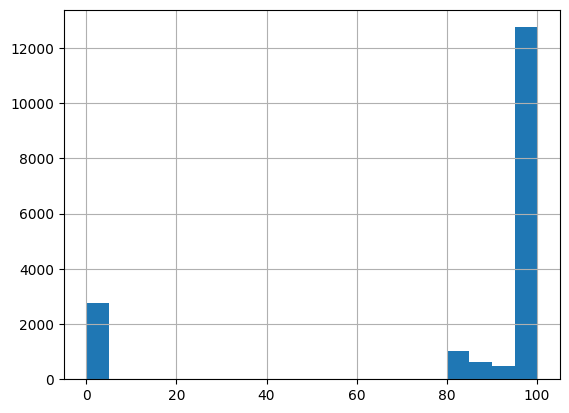

In [38]:
artists_df['similarity'].hist(bins=20)

Based on the Levenshtein distances we calculated, some artists did not have an exact match, but many had similarity scores between 80% and 100%. Approximately 15% of the artists could not be matched to any entry in the Spotify dataset, even when considering Levenshtein distance. For matches with a similarity above 80% but below 100%, most cases appear correct, with differences typically due to typos or minor variations in spelling. However, there are occasional mismatches, such as "Bob Marley" being incorrectly matched to "Jacob Marley." Despite these few errors, we decided to retain matches with scores above 80% for future purposes, as the majority seem reliable.

In [42]:
artists_df = artists_df.merge(spotify_df, left_on='spotify_match', right_on='artists_translit', how='left')

In [43]:
artists_df.head()

,id,name,url,pictureURL,name_clean,name_translit,spotify_match,similarity,artist_name,track_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artists_clean,artists_translit
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,malice mizer,malice mizer,None,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,diary of dreams,diary of dreams,diary of dreams,100.0,Diary Of Dreams,Beyond the Void,...,0.0409,0.032200,0.0468,0.1280,0.1850,100.009,4.0,industrial,diary of dreams,diary of dreams
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,carpathian forest,carpathian forest,carpathian forest,100.0,Carpathian Forest,Bloody Fucking Nekro Hell,...,0.1370,0.000218,0.0677,0.3350,0.0898,191.230,4.0,black-metal,carpathian forest,carpathian forest
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,moi dix mois,moi dix mois,None,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,bella morte,bella morte,bella morte,100.0,Bella Morte,Fall No More,...,0.0416,0.107000,0.8450,0.0796,0.2350,118.481,4.0,goth,bella morte,bella morte


In [44]:
artists_df.to_parquet('data/artists_spotify_matched.parquet', index=False)

# Adding Users information

In [10]:
pd.read_csv('data/tags.dat', sep='\t', encoding='latin1').head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [11]:
pd.read_csv('data/user_artists.dat', sep='\t').head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [12]:
pd.read_csv('data/user_friends.dat', sep='\t').head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [14]:
pd.read_csv('data/user_taggedartists-timestamps.dat', sep='\t').head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


In [15]:
pd.read_csv('data/user_taggedartists.dat', sep='\t').head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
